In [1]:
!pip install tensorflow==2.15.0
!pip install keras==2.15.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 78.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 8.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.17.0
    Uninstalling wrapt-1.17.0:
      Successfully uninstalled wrapt-1.17.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.metrics import Recall, AUC
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.models import load_model
import tensorflow as tf
import os

In [3]:
print(tf.__version__)

2.15.0


In [6]:
from google.colab import drive
import os

drive.mount('/content/drive')
zip_path = '/content/drive/My Drive/raw_data2.zip'
extract_path = '/content/raw_data2'

os.makedirs(extract_path, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import zipfile

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted files to: {extract_path}")
for root, dirs, files in os.walk(extract_path):
    print(f"Directory: {root}, Subdirectories: {dirs}, Files: {len(files)}")

Extracted files to: /content/raw_data2
Directory: /content/raw_data2, Subdirectories: ['raw_data'], Files: 0
Directory: /content/raw_data2/raw_data, Subdirectories: ['nsfw', 'no_nsfw'], Files: 0
Directory: /content/raw_data2/raw_data/nsfw, Subdirectories: [], Files: 5420
Directory: /content/raw_data2/raw_data/no_nsfw, Subdirectories: [], Files: 5550


In [8]:
data_dir = os.path.join(extract_path, "raw_data")

# Parameters
img_height = 224
img_width = 224
batch_size = 32

# Load the dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Check class names
print(f"Class names: {train_ds.class_names}")

Found 10970 files belonging to 2 classes.
Using 8776 files for training.
Found 10970 files belonging to 2 classes.
Using 2194 files for validation.
Class names: ['no_nsfw', 'nsfw']


In [9]:
os.makedirs('./cache_dir', exist_ok=True)

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache('./cache_dir/train_cache.tf-data').prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache('./cache_dir/val_cache.tf-data').prefetch(buffer_size=AUTOTUNE)

In [10]:
# Load MobileNetV2 base model
base_model = MobileNetV2(input_shape=(img_height, img_width, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model (we will fine-tune later)
base_model.trainable = False

# Define data augmentation for the training set
data_augmentation = Sequential([
    tf.keras.layers.RandomZoom(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.25)
])

# Define the full model
model = Sequential([
    Input(shape=(img_height, img_width, 3)),
    data_augmentation,
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])


9406464/9406464 [==============================] - 0s 0us/step


In [11]:
# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=[Recall(name='recall'), 'accuracy', AUC(name='auc')])

In [12]:
# Learning rate scheduler
def lr_schedule(epoch):
    initial_lr = 1e-3
    drop_rate = 0.5
    epoch_drop = 5.0
    lr = initial_lr * (drop_rate ** (epoch // epoch_drop))
    return lr

lr_callback = LearningRateScheduler(lr_schedule)

# Early stopping to monitor recall and stop training if it stops improving
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=3,
                               restore_best_weights=True)

In [13]:
# Train the model for initial training
model.fit(train_ds,
          validation_data=val_ds,
          epochs=20,
          callbacks=[lr_callback, early_stopping])

Epoch 1/20
275/275 [==============================] - 154s 503ms/step - loss: 1.0774 - recall: 0.8252 - accuracy: 0.8303 - auc: 0.9102 - val_loss: 0.5919 - val_recall: 0.8639 - val_accuracy: 0.8505 - val_auc: 0.9266 - lr: 0.0010
Epoch 2/20
275/275 [==============================] - 32s 114ms/step - loss: 0.5051 - recall: 0.8502 - accuracy: 0.8519 - auc: 0.9272 - val_loss: 0.5113 - val_recall: 0.7269 - val_accuracy: 0.8282 - val_auc: 0.9244 - lr: 0.0010
Epoch 3/20
275/275 [==============================] - 29s 106ms/step - loss: 0.4302 - recall: 0.8474 - accuracy: 0.8547 - auc: 0.9281 - val_loss: 0.6146 - val_recall: 0.5526 - val_accuracy: 0.7562 - val_auc: 0.9171 - lr: 0.0010
Epoch 4/20
275/275 [==============================] - 30s 109ms/step - loss: 0.4031 - recall: 0.8497 - accuracy: 0.8539 - auc: 0.9310 - val_loss: 0.4280 - val_recall: 0.8648 - val_accuracy: 0.8459 - val_auc: 0.9186 - lr: 0.0010
Epoch 5/20
275/275 [==============================] - 30s 110ms/step - loss: 0.3957 - r

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 batch_normalization (Batch  (None, 128)               512       
 Normalization)                                                  
                                                      

In [15]:
model.save('model_initial.h5', save_format='h5')
# model.save('model_initial.keras', save_format='keras')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [16]:
from tensorflow.keras.models import load_model
model = load_model('model_initial.h5')

# Unfreeze some layers for fine-tuning
base_model = model.get_layer('mobilenetv2_1.00_224')
base_model.trainable = True

fine_tune_at = 90  # Unfreeze from layer 100 onward
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False



optimizer = Adam(learning_rate=1e-4, weight_decay=1e-5)
class_weights = {0: 1.0, 1: 2.0}
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[Recall(name='recall'), 'accuracy', AUC(name='auc')])

In [17]:
def lr_schedule(epoch, initial_lr=1e-4, total_epochs=50):
    # Cosine Annealing
    lr = initial_lr * (1 + np.cos(np.pi * epoch / total_epochs)) / 2
    return lr

In [18]:
# Early stopping for fine tuning
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

In [19]:
history = model.fit(train_ds,
          validation_data=val_ds,
          epochs=50,
          class_weight=class_weights,
          callbacks=[lr_callback, early_stopping])

Epoch 1/50
275/275 [==============================] - 49s 119ms/step - loss: 0.4047 - recall: 0.9303 - accuracy: 0.8859 - auc: 0.9588 - val_loss: 1.2626 - val_recall: 0.5917 - val_accuracy: 0.7685 - val_auc: 0.8698 - lr: 0.0010
Epoch 2/50
275/275 [==============================] - 37s 134ms/step - loss: 0.2986 - recall: 0.9486 - accuracy: 0.9173 - auc: 0.9756 - val_loss: 1.0569 - val_recall: 0.5980 - val_accuracy: 0.7899 - val_auc: 0.9065 - lr: 0.0010
Epoch 3/50
275/275 [==============================] - 31s 112ms/step - loss: 0.2671 - recall: 0.9565 - accuracy: 0.9248 - auc: 0.9807 - val_loss: 0.7582 - val_recall: 0.7069 - val_accuracy: 0.7753 - val_auc: 0.8672 - lr: 0.0010
Epoch 4/50
275/275 [==============================] - 31s 113ms/step - loss: 0.2223 - recall: 0.9618 - accuracy: 0.9381 - auc: 0.9862 - val_loss: 0.6309 - val_recall: 0.9637 - val_accuracy: 0.8810 - val_auc: 0.9358 - lr: 0.0010
Epoch 5/50
275/275 [==============================] - 35s 126ms/step - loss: 0.2052 - re

In [20]:
model.save('model.h5')
model.save('model.keras')

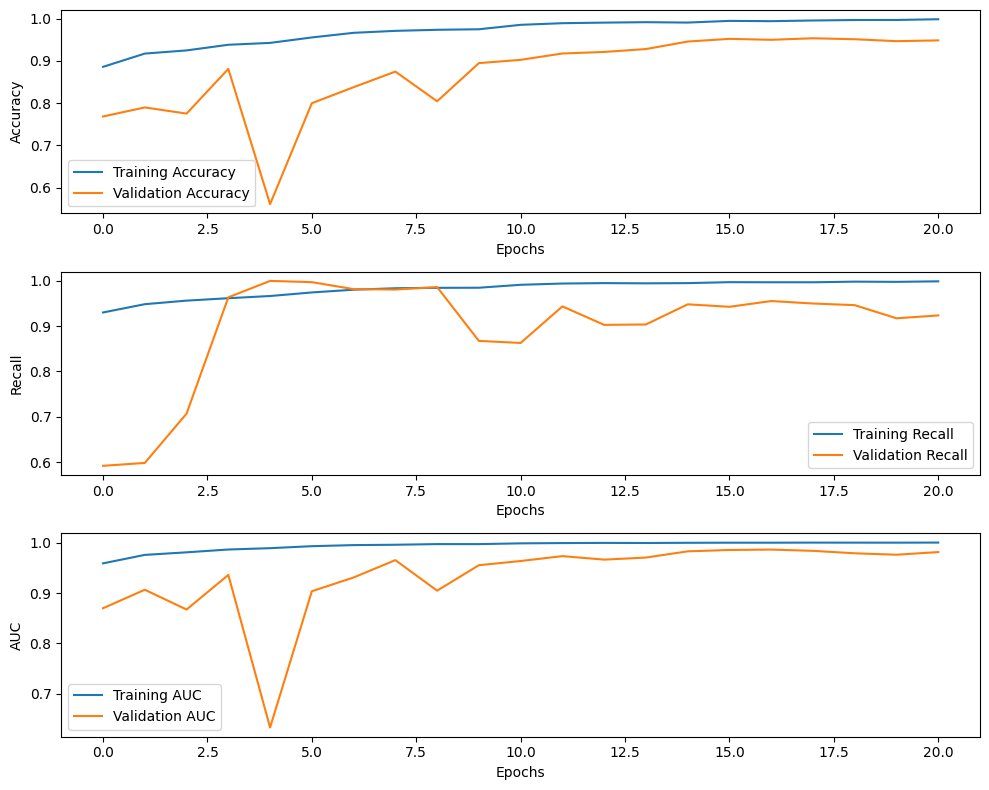

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))

# Accuracy plot
plt.subplot(3, 1, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Recall plot
plt.subplot(3, 1, 2)
plt.plot(history.history['recall'], label='Training Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

# AUC plot
if 'auc' in history.history:
    plt.subplot(3, 1, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.xlabel('Epochs')
    plt.ylabel('AUC')
    plt.legend()

plt.tight_layout()
plt.show()

In [22]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import matplotlib.pyplot as plt

1/1 [==============================] - 1s 1s/step
Prediction: NSFW


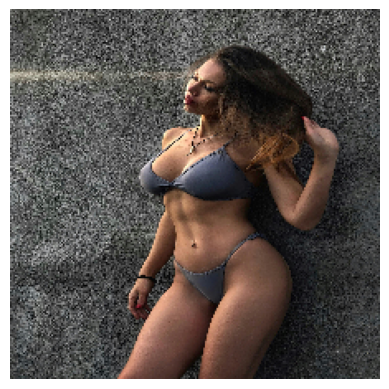

In [31]:
model = load_model('model.h5')

# Parameters
img_height = 224
img_width = 224

# Load and preprocess the test image
test_image_path = 'test_image_sexy.jpg'
img = load_img(test_image_path, target_size=(img_height, img_width))
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make a prediction
prediction = model.predict(img_array)
print("Prediction:", "NSFW" if prediction[0][0] > 0.5 else "Safe")

# Show the image
plt.imshow(img)
plt.axis('off')  # To hide the axes
plt.show()

In [ ]:
!pip install tensorflowjs

In [ ]:
!tensorflowjs_converter --input_format=keras model.h5 model_tfjs

2024-12-11 17:57:35.513128: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733939855.535604   69878 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733939855.542025   69878 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# tfjs_model_path = 'model_tfjs'

In [ ]:
!zip -r model_tfjs.zip model_tfjs